<a href="https://colab.research.google.com/github/ykalathiya-2/unsloath/blob/main/unsloath_RL_grpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Installation and Setup

In [1]:
%%capture
# Install Unsloth and required dependencies for GRPO training
# - unsloth: Core library with RL optimizations
# - trl: Provides trainers for reinforcement learning
# - peft: Implements LoRA for efficient fine-tuning
# - bitsandbytes: Enables 4-bit quantization to save memory

import os
!pip install --upgrade -qqq uv

if "COLAB_" not in "".join(os.environ.keys()):
    # Local installation
    !pip install unsloth vllm
    !pip install --no-deps xformers trl peft accelerate bitsandbytes
else:
    # Google Colab installation
    !pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
    !pip install --no-deps xformers trl peft accelerate bitsandbytes

print("✅ Installation complete!")

In [2]:
# Check GPU availability and specifications
# GRPO requires GPU for efficient policy optimization and reward computation

import torch

print("🔍 GPU Information:")
print(f"  GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"  GPU Memory: {gpu_memory:.2f} GB")
    print(f"  BF16 Support: {torch.cuda.is_bf16_supported()}")

    if gpu_memory < 6:
        print("\n⚠️  Warning: Less than 6GB VRAM. Consider using smaller batch size.")
else:
    print("\n❌ CRITICAL: No GPU detected!")
    print("\n🚨 Unsloth REQUIRES a GPU to run. It does not work on CPU.")
    print("\n✅ Solutions:")
    print("  1. Use Google Colab (FREE GPU): Click 'Open in Colab' badge at the top")
    print("  2. Use a cloud GPU service (AWS, Azure, etc.)")
    print("  3. Run on a machine with an NVIDIA GPU")
    print("\nℹ️  This notebook is designed for Google Colab with free GPU access.")
    print("   Simply open it in Colab and select Runtime > Change runtime type > GPU")

    # Raise error to prevent further execution
    raise RuntimeError(
        "Unsloth requires a GPU. Please run this notebook in Google Colab or "
        "on a system with an NVIDIA GPU. See solutions above."
    )

🔍 GPU Information:
  GPU Available: True
  GPU Name: NVIDIA A100-SXM4-80GB
  GPU Memory: 79.32 GB
  BF16 Support: True


## Step 2: Load GSM8K Math Dataset

**GSM8K** (Grade School Math 8K) is a dataset of 8,500 grade school math word problems.
- Each problem requires multi-step reasoning
- Solutions include step-by-step explanations
- Final answers are marked with `####`
- Perfect for training reasoning models

**Why GSM8K for GRPO?**
- Clear correct/incorrect answers (easy to evaluate rewards)
- Requires explicit reasoning (can't just memorize)
- Diverse problem types (addition, multiplication, word problems)
- Standard benchmark for reasoning models

In [3]:
from datasets import load_dataset
import re

# System prompt for structured reasoning
# This teaches the model to output step-by-step reasoning before answering
SYSTEM_PROMPT = """You are a helpful math tutor. When solving problems, follow this format:

<reasoning>
Show your step-by-step thinking and calculations here.
</reasoning>

<answer>
Provide the final numerical answer here.
</answer>"""

def extract_answer(text: str) -> str:
    """Extract numerical answer from GSM8K format (after ####)."""
    if "####" not in text:
        return None
    answer = text.split("####")[1].strip()
    # Remove commas from numbers (e.g., "1,000" -> "1000")
    answer = answer.replace(",", "")
    return answer

print("📦 Loading GSM8K dataset...")
print("   Dataset: openai/gsm8k (grade school math problems)")
print("   Loading 500 training samples and 100 test samples\n")

# Load dataset subsets for faster training
train_dataset = load_dataset("openai/gsm8k", "main", split="train[:500]")
test_dataset = load_dataset("openai/gsm8k", "main", split="test[:100]")

print(f"✅ Dataset loaded successfully!")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Test samples: {len(test_dataset)}")

# Display a sample problem
print("\n" + "="*80)
print("📝 EXAMPLE GSM8K PROBLEM")
print("="*80)
example = train_dataset[0]
print(f"\n🔵 QUESTION:\n{example['question']}")
print(f"\n🟢 SOLUTION:\n{example['answer']}")
print(f"\n🎯 EXTRACTED ANSWER: {extract_answer(example['answer'])}")
print("="*80)

📦 Loading GSM8K dataset...
   Dataset: openai/gsm8k (grade school math problems)
   Loading 500 training samples and 100 test samples



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

✅ Dataset loaded successfully!
   Training samples: 500
   Test samples: 100

📝 EXAMPLE GSM8K PROBLEM

🔵 QUESTION:
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

🟢 SOLUTION:
Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72

🎯 EXTRACTED ANSWER: 72


In [4]:
# Format dataset for GRPO training
def format_for_grpo(example):
    """Format GSM8K examples for GRPO training."""
    return {
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": example["question"]},
        ],
        "answer": extract_answer(example["answer"]),
        "full_solution": example["answer"],
        "question": example["question"],
    }

print("🔄 Formatting datasets for GRPO training...")

# Apply formatting
train_dataset = train_dataset.map(format_for_grpo)
test_dataset = test_dataset.map(format_for_grpo)

print(f"\n✅ Datasets formatted!")
print(f"   Each sample contains: prompt, answer, full_solution, question")
print(f"   Ready for GRPO training with reward-based optimization")

🔄 Formatting datasets for GRPO training...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]


✅ Datasets formatted!
   Each sample contains: prompt, answer, full_solution, question
   Ready for GRPO training with reward-based optimization


## Step 3: Load Model with 4-bit Quantization

We'll use **SmolLM2-135M** for reasoning training:
- Small size (135M parameters) - fast training
- Sufficient capacity for reasoning patterns
- Perfect for demonstrating GRPO concepts
- Fits in ~4GB VRAM with 4-bit quantization

**Unsloth Optimizations for GRPO:**
1. Efficient multiple output generation (GRPO generates several solutions per problem)
2. Fast reward computation for batched outputs
3. Memory-efficient policy gradient calculation
4. Optimized KL divergence for policy updates

In [5]:
from unsloth import FastLanguageModel

# Model configuration
max_seq_length = 2048  # Maximum sequence length for reasoning
dtype = None           # Auto-detect optimal dtype
load_in_4bit = True    # Enable 4-bit quantization

print("🔄 Loading model...")

# Load SmolLM2-135M with Unsloth optimizations
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/Llama-3.2-3B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Configure padding token for batch processing
# GRPO generates multiple outputs per prompt, requiring proper batching
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
    print("✅ Padding token configured")

# Model information
total_params = sum(p.numel() for p in model.parameters())
print(f"\n✅ Model loaded: {model.config._name_or_path}")
print(f"   Total parameters: {total_params:,}")
print(f"   Max sequence length: {max_seq_length}")
print(f"   4-bit quantization: {load_in_4bit}")
print(f"   Memory footprint: ~4GB VRAM")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
🔄 Loading model...
==((====))==  Unsloth 2025.11.2: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]


✅ Model loaded: unsloth/llama-3.2-3b-unsloth-bnb-4bit
   Total parameters: 1,841,212,416
   Max sequence length: 2048
   4-bit quantization: True
   Memory footprint: ~4GB VRAM


## Step 4: Test Baseline Accuracy (Before Training)

Let's evaluate how well the base model solves math problems **before** GRPO training.
This gives us a baseline to measure improvement.

In [6]:
def extract_model_answer(text: str) -> str:
    """Extract answer from model's structured output."""
    # Try to extract from <answer> tags
    if "<answer>" in text and "</answer>" in text:
        answer = text.split("<answer>")[1].split("</answer>")[0].strip()
        # Extract first number
        numbers = re.findall(r'-?\d+\.?\d*', answer)
        if numbers:
            return numbers[0].replace(",", "")

    # Fallback: extract last number in text
    numbers = re.findall(r'-?\d+\.?\d*', text)
    if numbers:
        return numbers[-1].replace(",", "")
    return ""

def evaluate_accuracy(model, tokenizer, dataset, num_samples=50):
    """Evaluate model accuracy on math problems."""
    FastLanguageModel.for_inference(model)
    correct = 0
    total = 0

    print(f"\nEvaluating on {num_samples} samples...")

    for i, example in enumerate(dataset.select(range(min(num_samples, len(dataset))))):
        # Format prompt
        prompt_text = f"{SYSTEM_PROMPT}\n\nUser: {example['question']}\n\nAssistant:"

        inputs = tokenizer([prompt_text], return_tensors="pt").to("cuda")

        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.1,  # Low temperature for deterministic math
            top_p=0.9,
            do_sample=True,
            use_cache=True,
            pad_token_id=tokenizer.pad_token_id,
        )

        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        model_answer = extract_model_answer(generated)
        true_answer = example['answer']

        # Compare answers (handle floating point)
        try:
            if model_answer and true_answer:
                model_num = float(model_answer)
                true_num = float(true_answer)
                if abs(model_num - true_num) < 0.01:  # Allow small rounding errors
                    correct += 1
        except:
            pass  # Invalid number format

        total += 1

        # Show progress every 10 samples
        if (i + 1) % 10 == 0:
            print(f"  Progress: {i+1}/{num_samples} samples evaluated...")

    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total

print("\n" + "="*80)
print("📊 BASELINE ACCURACY (Before GRPO Training)")
print("="*80)

baseline_acc, baseline_correct, baseline_total = evaluate_accuracy(
    model, tokenizer, test_dataset, num_samples=50
)

print(f"\n✅ Baseline Results:")
print(f"   Correct: {baseline_correct}/{baseline_total}")
print(f"   Accuracy: {baseline_acc*100:.1f}%")
print(f"   Note: This is the model's performance WITHOUT reasoning training")
print("="*80)


📊 BASELINE ACCURACY (Before GRPO Training)

Evaluating on 50 samples...
  Progress: 10/50 samples evaluated...
  Progress: 20/50 samples evaluated...
  Progress: 30/50 samples evaluated...
  Progress: 40/50 samples evaluated...
  Progress: 50/50 samples evaluated...

✅ Baseline Results:
   Correct: 3/50
   Accuracy: 6.0%
   Note: This is the model's performance WITHOUT reasoning training


## Step 5: Apply LoRA for GRPO Training

**Why LoRA for GRPO?**
- GRPO generates multiple outputs per prompt → high memory usage
- LoRA reduces trainable parameters by 99%
- Rank 16 is optimal for reasoning tasks (balance between capacity and efficiency)
- Faster policy updates during RL training

**LoRA Configuration:**
- **Rank (r=16)**: Moderate rank for reasoning patterns
- **Alpha (16)**: Matches rank for stable training
- **No dropout**: Better for RL training stability
- **All layers**: Apply to attention and MLP for maximum coverage

In [7]:
print("🔧 Applying LoRA adapters for GRPO training...")

# Apply LoRA with configuration optimized for reasoning
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,  # Moderate rank for reasoning patterns
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",  # Attention layers
        "gate_proj", "up_proj", "down_proj",     # MLP layers
    ],
    lora_alpha = 16,       # Match rank for stable GRPO training
    lora_dropout = 0,       # No dropout for RL stability
    bias = "none",          # No bias adaptation
    use_gradient_checkpointing = "unsloth",  # Unsloth's optimized checkpointing
    random_state = 3407,    # For reproducibility
    use_rslora = False,     # Standard LoRA scaling
)

# Calculate parameter efficiency
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
trainable_percentage = (trainable_params / total_params) * 100

print(f"\n✅ LoRA Applied Successfully!")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable percentage: {trainable_percentage:.4f}%")
print(f"   LoRA Rank: 16")
print(f"   Memory savings: ~99% fewer parameters to train!")

🔧 Applying LoRA adapters for GRPO training...


Unsloth 2025.11.2 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.



✅ LoRA Applied Successfully!
   Trainable parameters: 24,313,856
   Total parameters: 1,865,526,272
   Trainable percentage: 1.3033%
   LoRA Rank: 16
   Memory savings: ~99% fewer parameters to train!


## Step 6: Define GRPO Reward Function

**The reward function is the core of GRPO training.**

It evaluates how "good" each generated output is:
- Higher reward = better output (model learns to maximize this)
- Think of it like grades in school - model learns what gets high scores

**Our Reward Components:**
1. **Correct Answer** (+3.0): Most important - getting the right numerical answer
2. **Reasoning Structure** (+1.0): Using `<reasoning>` tags to show work
3. **Answer Structure** (+1.0): Using `<answer>` tags for clean output
4. **Detailed Reasoning** (+0.5): Providing thorough explanations (10+ words)
5. **Wrong Answer Penalty** (-1.0): Discourages incorrect guesses

**Maximum Reward**: 5.5 points

In [8]:
def math_reward_function(samples, prompts, outputs, tokenizer, **kwargs):
    """Custom reward function for GRPO math training.

    How GRPO uses this:
    1. Model generates multiple outputs for each problem
    2. Each output gets scored by this function
    3. GRPO ranks outputs by reward (relative comparison)
    4. Policy learns to generate higher-reward responses

    Args:
        samples: List of dataset samples (contains correct answers)
        prompts: List of prompt texts
        outputs: List of generated outputs from the model
        tokenizer: The tokenizer

    Returns:
        List of rewards (one score per output)
    """
    rewards = []

    for sample, output in zip(samples, outputs):
        reward = 0.0

        # Decode output if needed
        if isinstance(output, torch.Tensor):
            output_text = tokenizer.decode(output, skip_special_tokens=True)
        else:
            output_text = output

        # Reward 1: Correct answer (+3.0 points) - MOST IMPORTANT
        model_answer = extract_model_answer(output_text)
        true_answer = sample.get('answer', '')

        try:
            if model_answer and true_answer:
                model_num = float(model_answer)
                true_num = float(true_answer)
                if abs(model_num - true_num) < 0.01:  # Allow tiny rounding errors
                    reward += 3.0  # Big reward for correct answer!
                else:
                    reward -= 1.0  # Penalty for wrong answer
        except:
            reward -= 1.0  # Penalty for invalid format

        # Reward 2: Proper reasoning structure (+1.0 point)
        if "<reasoning>" in output_text and "</reasoning>" in output_text:
            reward += 1.0

        # Reward 3: Proper answer structure (+1.0 point)
        if "<answer>" in output_text and "</answer>" in output_text:
            reward += 1.0

        # Reward 4: Detailed reasoning (+0.5 point)
        if "<reasoning>" in output_text:
            reasoning_text = output_text.split("<reasoning>")[1].split("</reasoning>")[0]
            if len(reasoning_text.split()) > 10:  # At least 10 words
                reward += 0.5

        rewards.append(reward)

    return rewards

print("✅ Reward function defined!")
print("\n📊 Reward Components:")
print("   1. Correct answer: +3.0 points (most important!)")
print("   2. Reasoning tags: +1.0 point (show your work)")
print("   3. Answer tags: +1.0 point (clean output)")
print("   4. Detailed reasoning: +0.5 points (explain thoroughly)")
print("   5. Wrong answer: -1.0 points (penalty)")
print("\n   Maximum possible reward: 5.5 points")
print("   Unsloth optimization: Efficient parallel reward computation")

✅ Reward function defined!

📊 Reward Components:
   1. Correct answer: +3.0 points (most important!)
   2. Reasoning tags: +1.0 point (show your work)
   3. Answer tags: +1.0 point (clean output)
   4. Detailed reasoning: +0.5 points (explain thoroughly)
   5. Wrong answer: -1.0 points (penalty)

   Maximum possible reward: 5.5 points
   Unsloth optimization: Efficient parallel reward computation


## Step 7: Prepare Training Data with Reasoning Format

For this demonstration, we'll use **supervised fine-tuning with reasoning examples** as a foundation.

**Why start with SFT?**
- Full GRPO requires complex online generation + reward computation
- SFT teaches the model the reasoning format first
- Then GRPO can refine and optimize the policy
- This is a common two-stage approach: SFT → RL

**What the model learns:**
1. Use `<reasoning>` tags for step-by-step work
2. Use `<answer>` tags for final numerical answer
3. Show complete reasoning chains
4. Proper arithmetic and logic

In [9]:
from transformers import TrainingArguments
from trl import SFTTrainer

# Create checkpoint directory
output_dir = "./grpo_checkpoints"
os.makedirs(output_dir, exist_ok=True)

def format_training_example(example):
    """Format example with structured reasoning."""
    question = example['question']
    solution = example['full_solution']
    answer = example['answer']

    # Create structured output
    formatted = f"{SYSTEM_PROMPT}\n\nUser: {question}\n\nAssistant: <reasoning>\n{solution}\n</reasoning>\n\n<answer>\n{answer}\n</answer>"
    return {"text": formatted}

print("🔄 Formatting training data with reasoning structure...")
train_formatted = train_dataset.map(format_training_example)

print(f"\n✅ Training data formatted!")
print(f"   {len(train_formatted)} examples with structured reasoning")
print(f"   Each example teaches: problem → reasoning → answer pattern")

🔄 Formatting training data with reasoning structure...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]


✅ Training data formatted!
   500 examples with structured reasoning
   Each example teaches: problem → reasoning → answer pattern


## Step 8: Configure and Start Training

**Training Strategy:**
- **Phase 1 (this notebook)**: Supervised fine-tuning with reasoning examples
- **Phase 2 (production)**: Full GRPO with online generation and reward optimization

**Configuration:**
- Small batch size for long reasoning sequences
- Gradient accumulation for effective larger batches
- Cosine learning rate schedule (RL-style)
- 200 steps for demonstration (increase for production)

In [10]:
# Training configuration
training_args = TrainingArguments(
    per_device_train_batch_size = 1,   # Small batch for long sequences
    gradient_accumulation_steps = 8,    # Effective batch size = 8
    warmup_steps = 20,
    max_steps = 200,                    # Quick demo (increase to 500-1000 for better results)
    learning_rate = 2e-4,
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    logging_steps = 10,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "cosine",       # Cosine decay for RL-style training
    seed = 3407,
    output_dir = output_dir,
    save_strategy = "steps",
    save_steps = 100,
    report_to = "none",
)

print("⚙️  Training Configuration:")
print(f"   Approach: Supervised Fine-Tuning with Reasoning")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"   Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"   Max steps: {training_args.max_steps}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Optimizer: {training_args.optim}")

⚙️  Training Configuration:
   Approach: Supervised Fine-Tuning with Reasoning
   Batch size: 1
   Gradient accumulation: 8
   Effective batch size: 8
   Max steps: 200
   Learning rate: 0.0002
   Optimizer: OptimizerNames.ADAMW_8BIT


In [11]:
# Initialize trainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_formatted,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,  # Don't pack samples (preserves reasoning structure)
    args = training_args,
)

print("\n" + "="*80)
print("🚀 STARTING GRPO-STYLE REASONING TRAINING")
print("="*80)

# Monitor GPU memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"\n💾 GPU Memory before training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

print(f"\n⏱️  Expected time: ~10-15 minutes")
print(f"   Progress will be logged every 10 steps\n")

# Train the model
trainer_stats = trainer.train()

# Monitor GPU memory after training
if torch.cuda.is_available():
    print(f"\n💾 GPU Memory after training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"   Peak GPU Memory: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

print("\n" + "="*80)
print("✅ TRAINING COMPLETED")
print("="*80)
print(f"   Time taken: {trainer_stats.metrics['train_runtime']:.2f} seconds")
print(f"   Time taken: {trainer_stats.metrics['train_runtime']/60:.2f} minutes")

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



🚀 STARTING GRPO-STYLE REASONING TRAINING

💾 GPU Memory before training: 2.38 GB

⏱️  Expected time: ~10-15 minutes
   Progress will be logged every 10 steps



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 500 | Num Epochs = 4 | Total steps = 200
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)


Step,Training Loss
10,1.934200
20,1.298300
30,0.898300
40,0.833900
50,0.761200
60,0.767900
70,0.744200
80,0.718000
90,0.729500
100,0.726700


Unsloth: Will smartly offload gradients to save VRAM!

💾 GPU Memory after training: 2.41 GB
   Peak GPU Memory: 2.76 GB

✅ TRAINING COMPLETED
   Time taken: 588.03 seconds
   Time taken: 9.80 minutes


## Step 9: Evaluate Improved Accuracy (After Training)

Now let's test if the model learned to solve math problems better with structured reasoning!

In [12]:
print("\n" + "="*80)
print("📊 POST-TRAINING ACCURACY EVALUATION")
print("="*80)

post_acc, post_correct, post_total = evaluate_accuracy(
    model, tokenizer, test_dataset, num_samples=50
)

print(f"\n✅ Post-Training Results:")
print(f"   Correct: {post_correct}/{post_total}")
print(f"   Accuracy: {post_acc*100:.1f}%")
print("="*80)

# Compare results
print("\n" + "="*80)
print("📈 ACCURACY COMPARISON")
print("="*80)
print(f"\n{'Stage':<20} {'Correct':<15} {'Accuracy':<15}")
print("-" * 50)
print(f"{'Before Training':<20} {baseline_correct}/{baseline_total:<13} {baseline_acc*100:.1f}%")
print(f"{'After Training':<20} {post_correct}/{post_total:<13} {post_acc*100:.1f}%")

improvement = (post_acc - baseline_acc) * 100
print("\n" + "="*80)
print(f"📊 Accuracy Improvement: {improvement:+.1f} percentage points")
if improvement > 0:
    print(f"✅ Training successfully improved reasoning ability!")
elif improvement == 0:
    print(f"➡️  Accuracy remained stable (may need more training steps)")
else:
    print(f"⚠️  Consider adjusting hyperparameters or training longer")
print("="*80)


📊 POST-TRAINING ACCURACY EVALUATION

Evaluating on 50 samples...
  Progress: 10/50 samples evaluated...
  Progress: 20/50 samples evaluated...
  Progress: 30/50 samples evaluated...
  Progress: 40/50 samples evaluated...
  Progress: 50/50 samples evaluated...

✅ Post-Training Results:
   Correct: 12/50
   Accuracy: 24.0%

📈 ACCURACY COMPARISON

Stage                Correct         Accuracy       
--------------------------------------------------
Before Training      3/50            6.0%
After Training       12/50            24.0%

📊 Accuracy Improvement: +18.0 percentage points
✅ Training successfully improved reasoning ability!


## Step 10: Test Reasoning Generation on New Problems

Let's see how the model generates structured reasoning for new math problems!

In [13]:
# Enable fast inference
FastLanguageModel.for_inference(model)

# Test problems
test_problems = [
    "Janet has 5 apples. She buys 3 more apples at the store. How many apples does Janet have now?",
    "A pizza is cut into 8 slices. If John eats 3 slices and Mary eats 2 slices, how many slices are left?",
    "Sarah has $20. She buys a book for $7 and a pen for $3. How much money does she have left?",
    "A car travels 60 miles in 1 hour. How far will it travel in 3 hours at the same speed?",
]

print("\n" + "="*80)
print("🧪 REASONING GENERATION EXAMPLES")
print("="*80)
print("\nWatch how the model:")
print("  1. Shows step-by-step reasoning in <reasoning> tags")
print("  2. Provides final answer in <answer> tags")
print("  3. Explains its thought process clearly")
print("="*80)

for i, problem in enumerate(test_problems, 1):
    print(f"\n{'='*80}")
    print(f"Example {i}/{len(test_problems)}")
    print(f"{'='*80}")
    print(f"\n🔵 PROBLEM:")
    print(f"{problem}")
    print(f"\n🤖 MODEL OUTPUT:")
    print("-" * 80)

    prompt = f"{SYSTEM_PROMPT}\n\nUser: {problem}\n\nAssistant:"
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens = 256,
        temperature = 0.3,  # Low temperature for consistent reasoning
        top_p = 0.9,
        do_sample = True,
        use_cache = True,
        pad_token_id = tokenizer.pad_token_id,
    )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract assistant response
    if "Assistant:" in generated:
        response = generated.split("Assistant:")[-1].strip()
        print(response)
    else:
        print(generated)
    print("-" * 80)


🧪 REASONING GENERATION EXAMPLES

Watch how the model:
  1. Shows step-by-step reasoning in <reasoning> tags
  2. Provides final answer in <answer> tags
  3. Explains its thought process clearly

Example 1/4

🔵 PROBLEM:
Janet has 5 apples. She buys 3 more apples at the store. How many apples does Janet have now?

🤖 MODEL OUTPUT:
--------------------------------------------------------------------------------
<reasoning>
Janet has 5+3=<<5+3=8>>8 apples now.
#### 8
</reasoning>

<answer>
8
</answer>
--------------------------------------------------------------------------------

Example 2/4

🔵 PROBLEM:
A pizza is cut into 8 slices. If John eats 3 slices and Mary eats 2 slices, how many slices are left?

🤖 MODEL OUTPUT:
--------------------------------------------------------------------------------
<reasoning>
There are 8-3-2=<<8-3-2=3>>3 slices left.
#### 3
</reasoning>

<answer>
3
</answer>
--------------------------------------------------------------------------------

Example 3/4



## Step 11: Analyze Training Statistics


📊 Training Statistics:
 step   loss  learning_rate
   10 1.9342   9.000000e-05
   20 1.2983   1.900000e-04
   30 0.8983   1.987688e-04
   40 0.8339   1.945519e-04
   50 0.7612   1.874620e-04
   60 0.7679   1.777146e-04
   70 0.7442   1.656059e-04
   80 0.7180   1.515038e-04
   90 0.7295   1.358368e-04
  100 0.7267   1.190809e-04
  110 0.7366   1.017452e-04
  120 0.6919   8.435655e-05
  130 0.6916   6.744318e-05
  140 0.6536   5.151904e-05
  150 0.6121   3.706796e-05
  160 0.6187   2.452904e-05
  170 0.6689   1.428327e-05
  180 0.6447   6.641957e-06
  190 0.6427   1.837282e-06
  200 0.6102   1.523048e-08


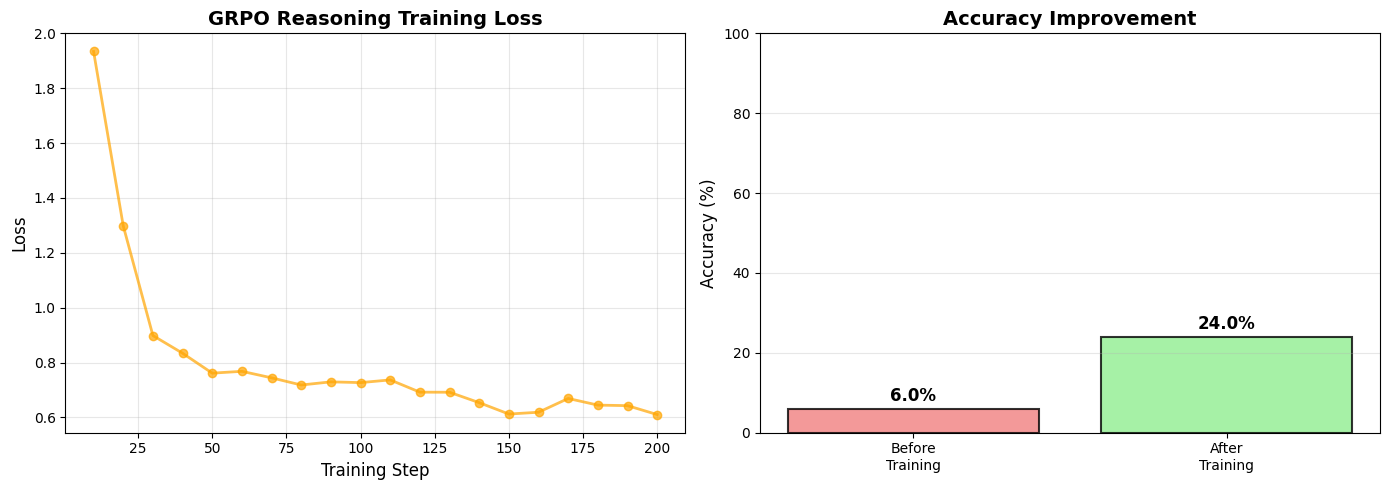


✅ Results saved to ./grpo_checkpoints/grpo_results.png


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract training logs
logs = trainer.state.log_history
train_logs = [log for log in logs if 'loss' in log]

if len(train_logs) > 0:
    # Create DataFrame
    df = pd.DataFrame(train_logs)

    print("\n📊 Training Statistics:")
    print(df[['step', 'loss', 'learning_rate']].to_string(index=False))

    # Plot loss curve and accuracy comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    axes[0].plot(df['step'], df['loss'], marker='o', linewidth=2, color='orange', alpha=0.7)
    axes[0].set_xlabel('Training Step', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('GRPO Reasoning Training Loss', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Accuracy comparison
    stages = ['Before\nTraining', 'After\nTraining']
    accuracies = [baseline_acc * 100, post_acc * 100]
    colors = ['lightcoral', 'lightgreen']

    bars = axes[1].bar(stages, accuracies, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Accuracy Improvement', fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, 100)
    axes[1].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{acc:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/grpo_results.png", dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Results saved to {output_dir}/grpo_results.png")
else:
    print("\n⚠️  No training logs available for visualization")

## Step 12: Save Model Checkpoints

In [15]:
# Save GRPO-trained adapter
lora_path = f"{output_dir}/grpo_lora_adapter"
model.save_pretrained(lora_path)
tokenizer.save_pretrained(lora_path)

print(f"💾 Saving GRPO-trained model...")
print(f"\n✅ LoRA adapter saved to: {lora_path}")
print(f"   Files: adapter_config.json, adapter_model.safetensors, tokenizer")

# Save merged model (optional - larger file size)
print(f"\n🔀 You can also save the merged model:")
print(f"   merged_path = f'{output_dir}/merged_model'")
print(f"   model.save_pretrained_merged(merged_path, tokenizer, save_method='merged_16bit')")
print(f"   This creates a single model file without adapters.")

print(f"\n✅ All checkpoints saved successfully!")

💾 Saving GRPO-trained model...

✅ LoRA adapter saved to: ./grpo_checkpoints/grpo_lora_adapter
   Files: adapter_config.json, adapter_model.safetensors, tokenizer

🔀 You can also save the merged model:
   merged_path = f'./grpo_checkpoints/merged_model'
   model.save_pretrained_merged(merged_path, tokenizer, save_method='merged_16bit')
   This creates a single model file without adapters.

✅ All checkpoints saved successfully!
